In [5]:
import pandas as pd
import math
import operator
import os
import shutil
from matplotlib import pyplot as plt

In [12]:
df_cat_a228 = pd.read_csv('Stock Category Model Results\df_test_bilstm 500 epochs.csv')
df_cat_a228.drop('Unnamed: 0', inplace=True, axis=1)
df_cat_a228_lstm = pd.read_csv('Stock Category Model Results\df_test_lstm 500 epochs.csv')
df_cat_a228_lstm.drop('Unnamed: 0', inplace=True, axis=1)



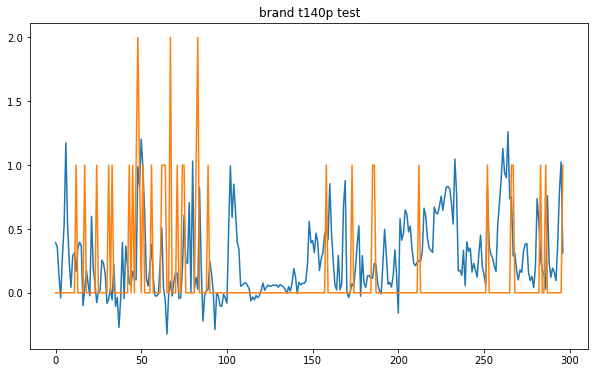

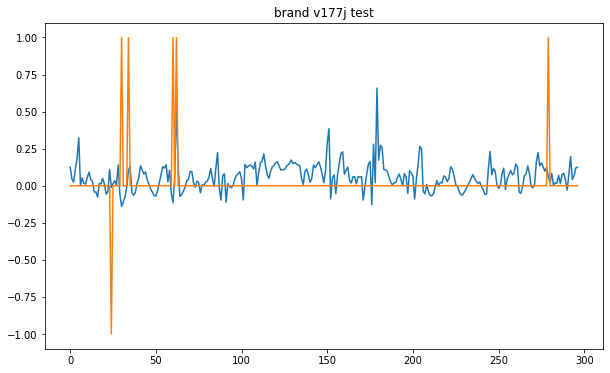

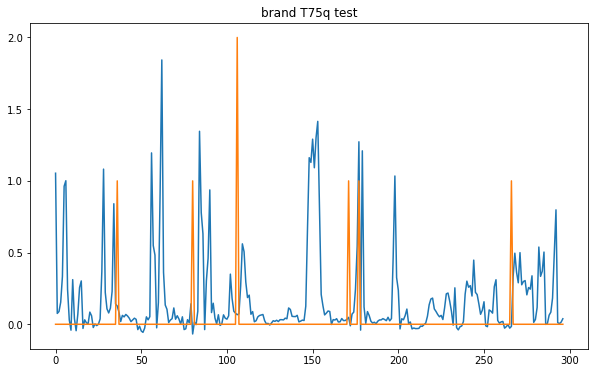

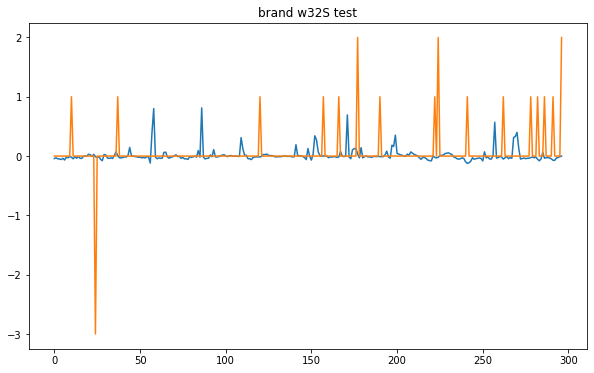

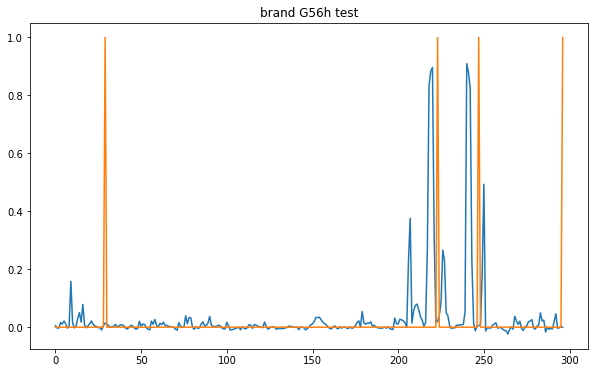

In [10]:
for column in df_cat_a228.columns:
    if "test" in column:
        column_name_test = column
        column_name_actual = column.replace(" test", "") + " actual"

        c_test_data = df_cat_a228[column_name_test].values
        c_actual_data = df_cat_a228[column_name_actual].values

        plt.figure(figsize=(10,6))
        title = column + ' bilstm'
        plt.title(title)
        plt.legend()
        plt.plot(c_test_data)
        plt.plot(c_actual_data)
        plt.show()
    else:
        break



No handles with labels found to put in legend.


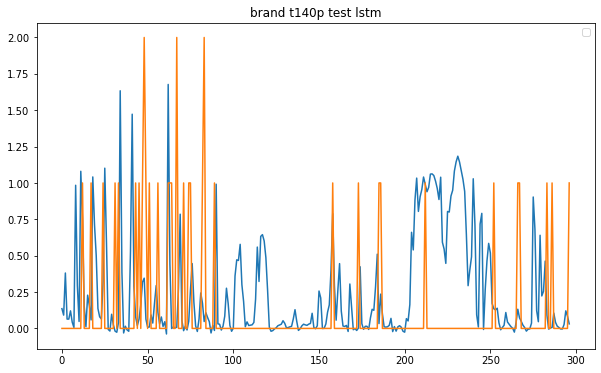

No handles with labels found to put in legend.


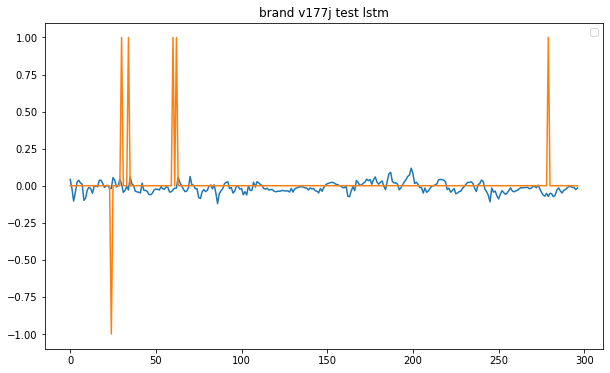

No handles with labels found to put in legend.


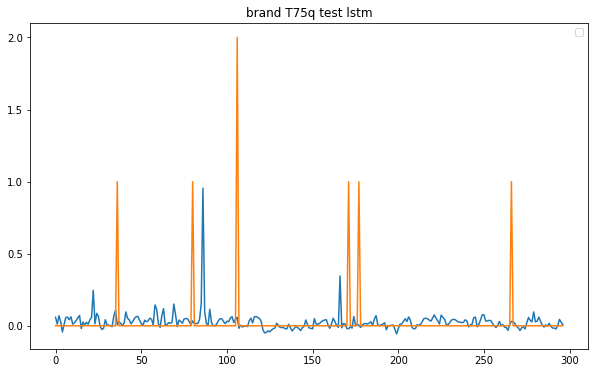

No handles with labels found to put in legend.


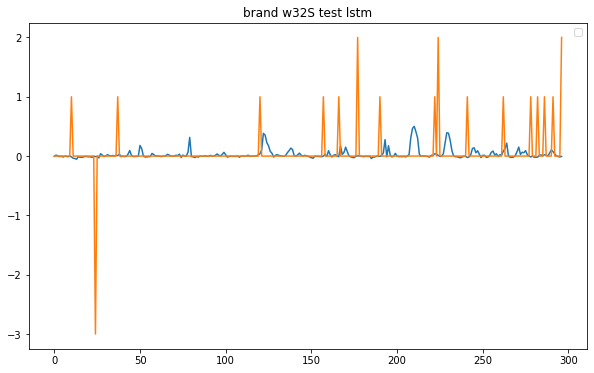

No handles with labels found to put in legend.


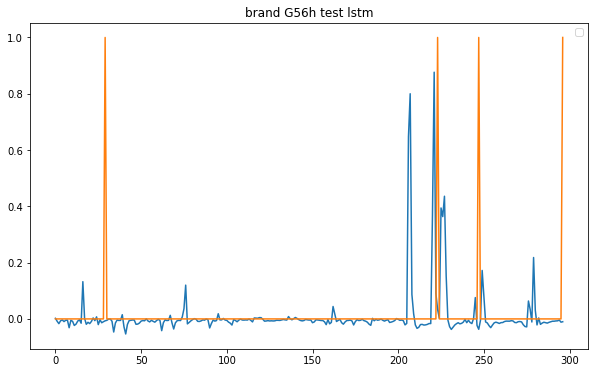

In [14]:
for column in df_cat_a228_lstm.columns:
    if "test" in column:
        column_name_test = column
        column_name_actual = column.replace(" test", "") + " actual"

        c_test_data = df_cat_a228_lstm[column_name_test].values
        c_actual_data = df_cat_a228_lstm[column_name_actual].values

        plt.figure(figsize=(10,6))
        title = column + ' lstm'
        plt.title(title)
        plt.legend()
        plt.plot(c_test_data)
        plt.plot(c_actual_data)
        plt.show()
    else:
        break

